# Notes:
* IDs in dm_apps do not conflict with these IDs
    * confirm prior to import to full production Db
    * ALT: redo ID with another format
        * Kevin opinion: it would be nice to have the IDs look completely different between species for readability, but there may be reasons why 12-13 character ids are impractical
    * NB: since dates and sites are encoded into these ID, they may not be compatible with int filetypes
        * dm_apps looks to use char fields with max_length of 100, so should be fine... confirm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
df_FD = pd.read_pickle('cleaned_MASTER_dataset.pickle')  # fish details
df_LF = pd.read_pickle('cleaned_LENGTHFREQ_dataset.pickle')  # length frequencies
df_SD = pd.read_pickle('cleaned_LOGBOOK_dataset.pickle')  # logbook / sample data

# Generate Unique IDs - Length Frequencies

In [3]:
# replace non-numeric data with made up site numbers
id_replacements = {
    '1A': 90,
    '1B': 91,
    'EricMcFarlane': 92,
    'JimmyMacFarlane': 93,
    'JohnAlbertCoady': 94
}
# df_LF.loc[df_LF.SITE1.isnull(), 'SITE1'] = 0  # set missing sites to 0
# NOTE: null sites can be set during query (fillna(0))
df_LF = df_LF.replace({'SITE1': id_replacements})

In [4]:
# 'unique' id column (note ambiguities, and solve later)
df_LF['id'] = (
    df_LF.DATETIME.dt.year*1_000_000 
    + df_LF.DATETIME.dt.month*10_000 
    + df_LF.DATETIME.dt.day*100 
    + df_LF.SITE1.fillna(0).astype(int)
).astype('Int64')

# new sample indicator
df_LF['new_sample'] = df_LF.lgth.diff() < 0

# new id indicator
df_LF['new_id'] = df_LF.id.diff() != 0

In [5]:
# update ids for ambiguous entries
duplicated_ids_LF = list(df_LF[~df_LF.new_id & df_LF.new_sample].id)

In [6]:
# only run this once
if df_LF.id.max() < 2_100_000_000:

    # add 1B to duplicate ids
    df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] = df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] + 1_000_000_000

    # add an extra billion to every other id, so that all are now distinct
    previous_lgth = 0
    multiplier = False

    for i, row in df_LF[df_LF.id > 2_900_000_000].iterrows():

        current_lgth = row['lgth']
        if previous_lgth > current_lgth:
            multiplier = not multiplier

        df_LF.loc[i, 'id'] = row.id + 1_000_000_000*multiplier

        previous_lgth = current_lgth

In [7]:
# LOOKS GOOD: check to see if it worked
df_LF[df_LF.id.isin([x + 1_000_000_000 for x in duplicated_ids_LF]) | df_LF.id.isin([x + 2_000_000_000 for x in duplicated_ids_LF])]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id
3102,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,235,1,235,1998-05-01,5,<NA>,<NA>,2998050105,True,True
3103,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,240,1,240,1998-05-01,5,<NA>,<NA>,2998050105,False,False
3104,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,245,4,245,1998-05-01,5,<NA>,<NA>,2998050105,False,False
3105,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,250,2,250,1998-05-01,5,<NA>,<NA>,2998050105,False,False
3106,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,255,3,255,1998-05-01,5,<NA>,<NA>,2998050105,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10848,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,250,25,250,2018-06-13,64,<NA>,<NA>,3018061364,False,False
10849,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,255,13,255,2018-06-13,64,<NA>,<NA>,3018061364,False,False
10850,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,260,1,260,2018-06-13,64,<NA>,<NA>,3018061364,False,False
10851,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,235,2,235,2018-06-13,64,<NA>,<NA>,4018061364,True,False


In [8]:
# GOOD:
df_LF[df_LF.id.isin(duplicated_ids_LF)]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id


# Length Bins

In [9]:
# use the same bins as used in the herring database
df_LF['length_bin_id'] = (df_LF.lgth - df_LF.lgth % 5) / 10

In [10]:
# error check: how many total fish cm (binned)
(df_LF['length_bin_id'] * df_LF['freq']).sum()

5076496.0

In [11]:
gaspereau_lengthfrequency = df_LF.groupby(['id', 'length_bin_id']).sum('freq').reset_index()[['freq', 'length_bin_id', 'id']].rename({
    'freq': 'count', 
    'length_bin_id': 'length_bin_id', 
    'id': 'sample_id'
}, axis=1)

In [12]:
# LOOKS GOOD: error check: how many total fish cm (binned)
(gaspereau_lengthfrequency['length_bin_id'] * gaspereau_lengthfrequency['count']).sum()

5076496.0

# Save the gaspereau_lengthfrequency table

In [20]:
# this can link to herring_lengthbin (it goes from 0 to 200cm - more than enough)
if False:  # change this to overwrite/resave
    gaspereau_lengthfrequency.to_pickle('gaspereau_lengthfrequency.pickle')

In [14]:
# lets look at a few histograms, just to check
sample_ids = gaspereau_lengthfrequency.sample_id.unique()

----------------------------------------------
Histogram: 1999052035


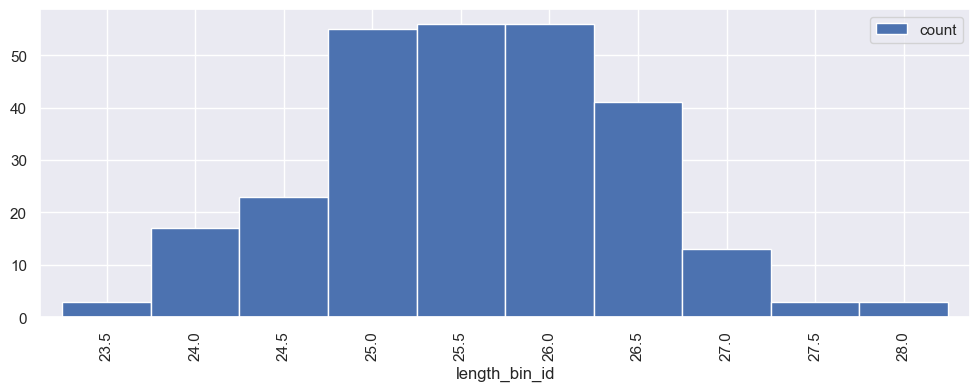

----------------------------------------------
Histogram: 2019062141


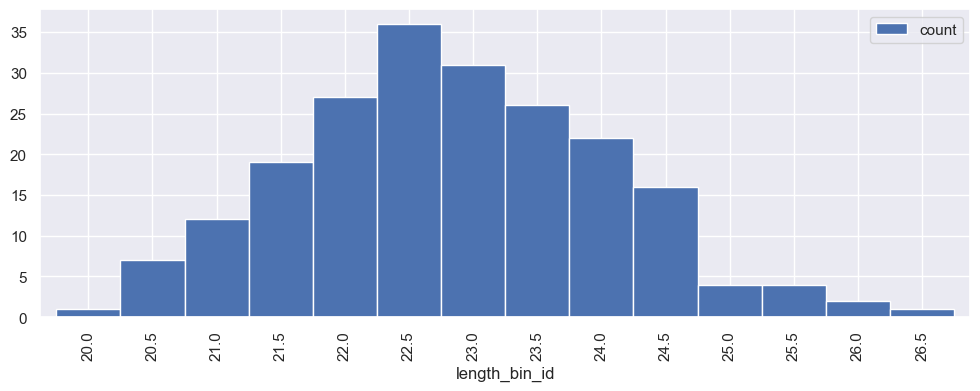

----------------------------------------------
Histogram: 2002051526


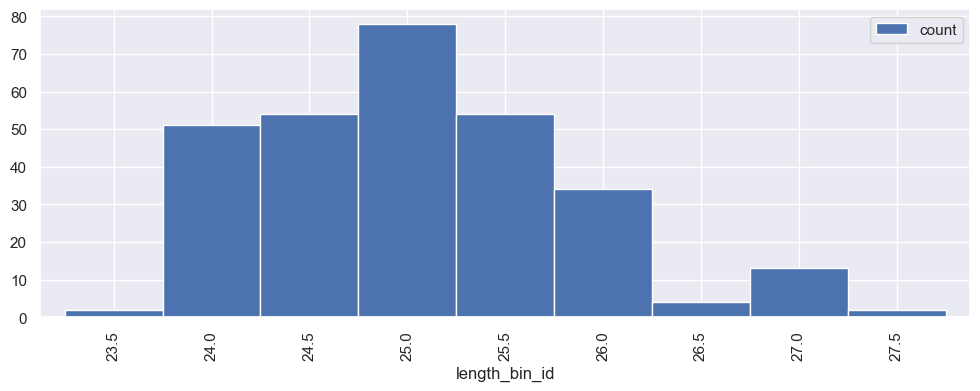

----------------------------------------------
Histogram: 2013052212


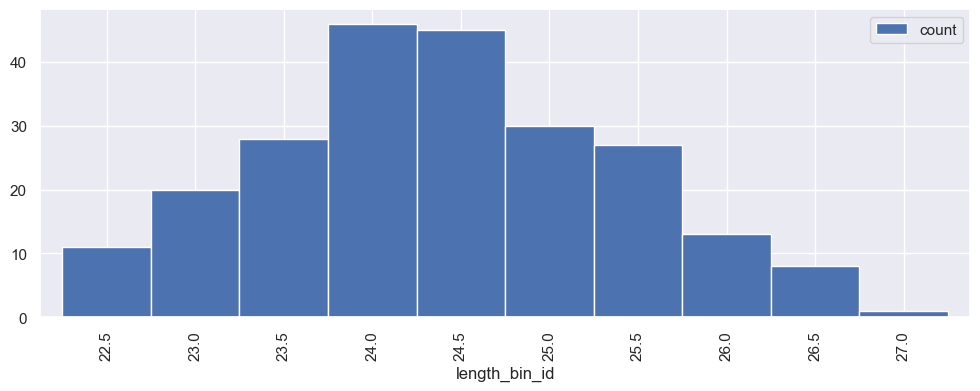

----------------------------------------------
Histogram: 2019052425


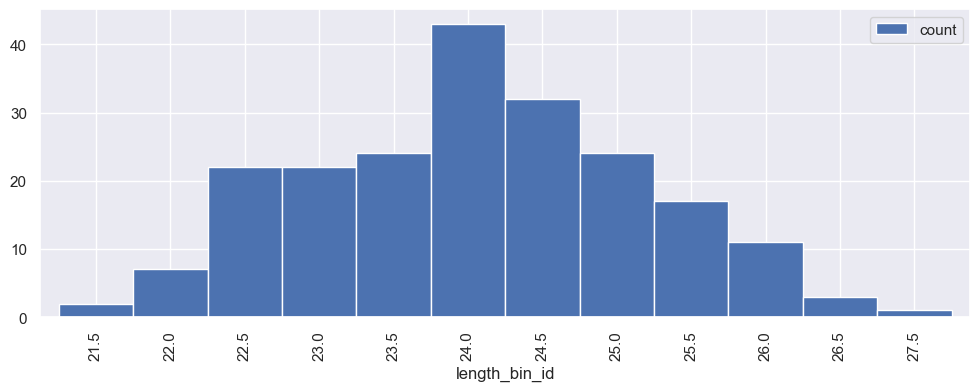

In [15]:
# random samples - check the histogram
for i in range(5):
    sample_id = np.random.choice(sample_ids)
    print('----------------------------------------------\nHistogram:', sample_id)
    gaspereau_lengthfrequency.loc[gaspereau_lengthfrequency.sample_id==sample_id, ['count', 'length_bin_id']].plot(kind='bar', x='length_bin_id', y='count', width=1, figsize=(12,4))
    plt.show()

# Samples

In [16]:
# same site replacements from LF
df_SD = df_SD.replace({'SITE1': id_replacements})

# 'unique' id column
df_SD['id'] = (
    df_SD.YEAR.astype(int)*1_000_000 
    + df_SD.MM.fillna(0).astype(int)*10_000
    + df_SD.DD.fillna(0).astype(int)*100
    + df_SD.SITE1.fillna(0).astype(int)
).astype('Int64')

# duplicated ids
duplicated_ids_SD = set(df_SD[df_SD.duplicated('id', keep=False)].id)

In [17]:
# some of these ids end up with an extra digit
if df_SD.id.max() < 2_100_000_000:
    
    # initialise number of handled repeats as zero for each id
    n_repeats = dict(zip(duplicated_ids_SD, [0 for x in duplicated_ids_SD]))
    
    for i, row in df_SD[df_SD.id.isin(duplicated_ids_SD)].iterrows():
        df_SD.loc[i, 'id'] = row['id'] + 1_000_000_000 * int(n_repeats[row['id']] + 1)
        n_repeats[row['id']] += 1

In [18]:
# check to see if it worked
check_SD = set()
for idx in list(df_SD[df_SD.id > 2_100_000_000].id):
    check_SD.add(idx % 1_000_000_000)

# looks good
check_SD, duplicated_ids_SD

({4061001, 988040037, 988052348, 997061258},
 {1988040037, 1988052348, 1997061258, 2004061001})

In [19]:
# another check, looks good
df_SD[df_SD.id > 2_100_000_000]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
2346,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,36076.000,16363.800,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,2988040037
2452,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1988,5,23,<NA>,7015.000,3182.000,13,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1988-05-23,2988052348
2531,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,4008.000,1818.000,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,3988040037
2535,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1988,5,23,<NA>,4008.000,1818.000,13,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1988-05-23,3988052348
2570,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,3006.000,1363.500,12,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,4988040037
2571,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,3006.000,1363.500,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,5988040037
2608,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,2405.000,1090.900,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,6988040037
2633,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,2004.000,909.000,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,7988040037
2680,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,1503.000,681.700,12,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,8988040037
2731,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,1002.000,454.500,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,9988040037


In [26]:
# perfect
df_SD[df_SD.duplicated('id')]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id


# add null sample data where there is unmatched length frequencies

In [37]:
df_SD = pd.concat([df_SD, pd.DataFrame(df_LF[~df_LF.id.isin(set(df_SD.id))].id.unique(), columns=['id'])]).reset_index(drop=True)

# NOTE: if a datetime column is useful, pd.to_datetime(id // 100) should work
# alt could use a more complicated JOIN to add SITE1 as well
# leave this way for now

In [39]:
# all LF data are in the SD dataframe
df_LF[~df_LF.id.isin(set(df_SD.id))]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
